In [3]:
from tensorflow import keras
from kdg.utils import generate_spirals, generate_gaussian_parity, generate_polynomial, generate_sinewave
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.io import savemat, loadmat

from kdn_all_w_apprx_lin_npar import kdn as kdn1
from kdn_all_w_lin_npar import kdn_all_w as kdn2
from kdn_all_w_meta_poly_npar import kdn_all_w_meta_poly as kdn3

In [2]:
# user params
kdn_versions = [
    "KDN approx lin",
    "KDN strict lin",
    "KDN meta poly"
]

### Visualize the Class Posteriors and Likelihoods

In [3]:
# create dat
X, y = generate_gaussian_parity(10000)
X_val, y_val = generate_gaussian_parity(500)
X_test, y_test = generate_gaussian_parity(1000)

In [4]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [5]:
# network architecture [8, 8, 2]
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(8, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(8, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [6]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Epoch 00102: early stopping


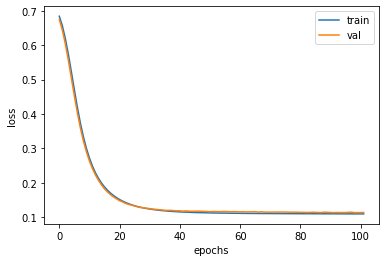

In [7]:
# plot the training loss and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(["train", "val"])

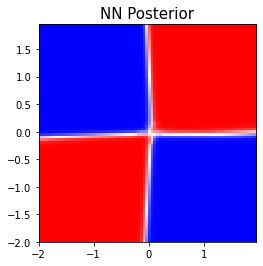

In [8]:
# plot the NN class posteriors
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

proba_nn = nn.predict(grid_samples)

fig, ax = plt.subplots()
ax1 = ax.imshow(
        proba_nn[:, 0].reshape(80, 80).T,
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="bwr",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
ax.set_title("NN Posterior", fontsize=15)
ax.set_aspect("equal")

In [123]:
kdn1_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 2,
    "verbose": False
}

kdn2_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 1,
    "verbose": False
}

kdn3_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 2,
    "verbose": False
}

In [11]:
# define the grid
df = {}
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

nn_accuracy = np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
proba_nn = nn.predict(grid_samples)
df["nn_acc"] = nn_accuracy
df["nn_proba"] = proba_nn

for i, kdn_version in enumerate(kdn_versions):
    if i == 0:
        model_kdn = kdn1(nn, **kdn1_kwargs)
        name = "kdn1"
    if i == 1:
        model_kdn = kdn2(nn, **kdn2_kwargs)
        name = "kdn2"
    if i == 2:
        model_kdn = kdn3(nn, **kdn3_kwargs)
        name = "kdn3"
    
    print("Training..." + name)
    model_kdn.fit(X, y)
    kdn_accuracy = np.mean(model_kdn.predict(X_test)==y_test)
    proba_kdn, likelihoods = model_kdn.predict_proba(grid_samples, return_likelihoods=True)

    df[name + "_acc"] = kdn_accuracy
    df[name + "_proba"] = proba_kdn
    df[name + "_lh"] = likelihoods

Training...kdn1
Training...kdn2
Training...kdn3


#### Class Posterior Probabilities

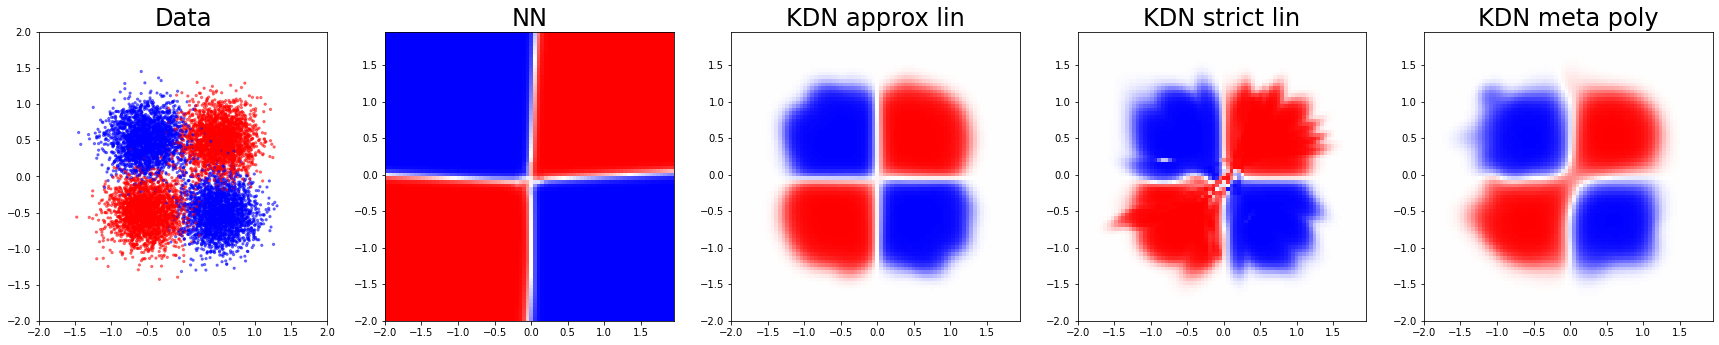

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(30, 150))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    df["nn_proba"][:, 0].reshape(80, 80),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
# fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    df["kdn1_proba"][:, 0].reshape(80, 80),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title(kdn_versions[0], fontsize=24)
ax[2].set_aspect("equal")
# fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

ax3 = ax[3].imshow(
    df["kdn2_proba"][:, 0].reshape(80, 80),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title(kdn_versions[1], fontsize=24)
ax[3].set_aspect("equal")
# fig.colorbar(ax3, ax=ax[3], fraction=0.046, pad=0.04)

ax4 = ax[4].imshow(
    df["kdn3_proba"][:, 0].reshape(80, 80),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[4].set_title(kdn_versions[2], fontsize=24)
ax[4].set_aspect("equal")
# fig.colorbar(ax4, ax=ax[4], fraction=0.046, pad=0.04)

# fig.savefig("KDN_one_gaussian_per_polytope.pdf", bbox_inches='tight')
plt.show()


#### Class Likelihoods

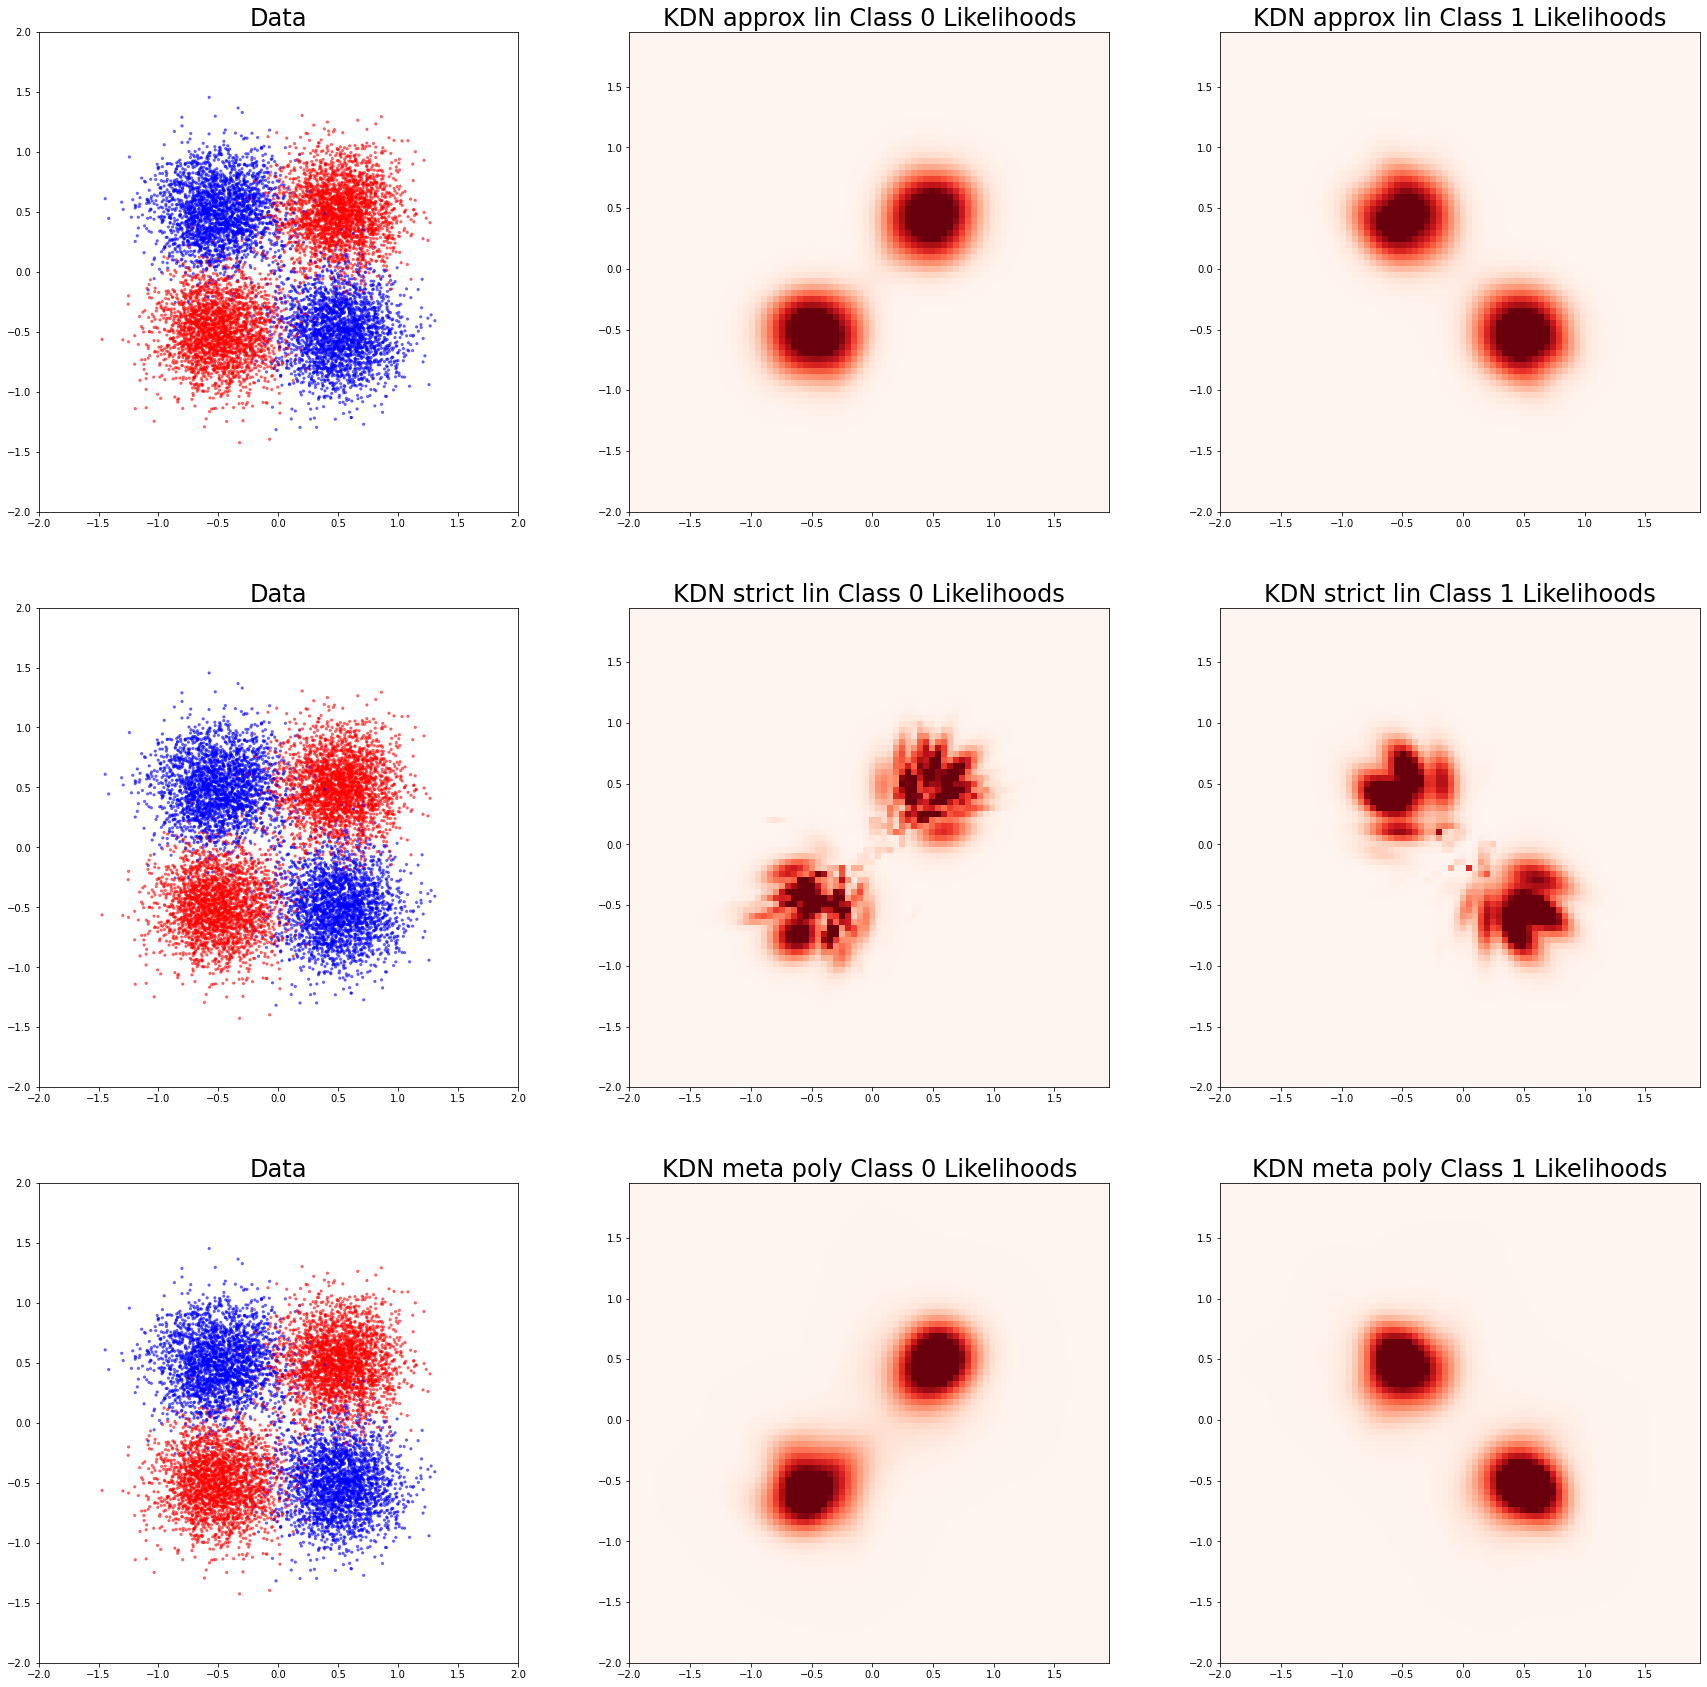

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))

names = ['kdn1', 'kdn2', 'kdn3']
for i in range(3):
    import matplotlib
    cmap = matplotlib.cm.get_cmap('bwr')
    clr = [cmap(255*i) for i in y]
    ax[i][0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
    ax[i][0].set_xlim(-2, 2)
    ax[i][0].set_ylim(-2, 2)
    ax[i][0].set_title("Data", fontsize=24)
    ax[i][0].set_aspect("equal")

    ax1 = ax[i][1].imshow(
        df[names[i]+'_lh'][:, 0].reshape(80, 80),
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="Reds",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
    ax[i][1].set_title(kdn_versions[i] + " Class 0 Likelihoods", fontsize=24)
    ax[i][1].set_aspect("equal")
    # fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

    ax2 = ax[i][2].imshow(
        df[names[i]+'_lh'][:, 1].reshape(80, 80),
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="Reds",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
    ax[i][2].set_title(kdn_versions[i] + " Class 1 Likelihoods", fontsize=24)
    ax[i][2].set_aspect("equal")
    # fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)


In [174]:
# save plot data
savemat("plot_data.mat", df)

### Error Curves (In Distribution)

In [64]:
# create out-of-distribution samples
def generate_ood_samples(n, inbound=[2, -2], outbound=[6, -6]):
    Xood = []
    i = 0
    while True:
        x1 = (outbound[0] - outbound[1])*np.random.random_sample() - outbound[0]
        x2 = (outbound[0] - outbound[1])*np.random.random_sample() - outbound[0]
        if (-2 < x1 < 2) and (-2 < x2 < 2):
            continue
        else:
            Xood.append([x1, x2])
            i += 1
        if i >= 1000:
            break
    Xood = np.array(Xood)
    return Xood

In [166]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [170]:
# run the experiment
sample_size = [50, 100, 500, 1000, 5000, 10000]
reps = 5
n_test = 1000

accuracy_nn = []
accuracy_kdn1 = []
accuracy_kdn2 = []
accuracy_kdn3 = []

mmcIn_nn = []
mmcIn_kdn1 = []
mmcIn_kdn2 = []
mmcIn_kdn3 = []

mmcOut_nn = []
mmcOut_kdn1 = []
mmcOut_kdn2 = []
mmcOut_kdn3 = []

roc_nn = []
roc_kdn1 = []
roc_kdn2 = []
roc_kdn3 = []

fpr_nn = []
fpr_kdn1 = []
fpr_kdn2 = []
fpr_kdn3 = []

reps_list = []
sample_list = []
ddf = {}

true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

# run experiment
for sample in sample_size:
    print("Doing sample %d" % sample)
    for ii in range(reps):
        X, y = generate_gaussian_parity(sample)
        X_test, y_test = generate_gaussian_parity(n_test)
        X_ood = generate_ood_samples(n_test)

        # train Vanilla NN
        nn = getNN()
        nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        accuracy_nn.append(
            np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
        )
        mmcIn_nn.append(
            np.mean(np.max(nn.predict(X_test), axis=1))
        )
        mmcOut_nn.append(
            np.mean(np.max(nn.predict(X_ood), axis=1))
        )
        nn_in_conf = np.max(nn.predict(X_test), axis=1)
        nn_out_conf = np.max(nn.predict(X_ood), axis=1)
        nn_conf = np.hstack((nn_in_conf, nn_out_conf))
        roc_nn.append(
            roc_auc_score(true_labels, nn_conf)
        )
        fpr_nn.append(
            fpr_at_95_tpr(nn_in_conf, nn_out_conf)
        )
        
        # train KDN1
        model_kdn = kdn1(nn, **kdn1_kwargs)
        model_kdn.fit(X, y)

        accuracy_kdn1.append(
            np.mean(model_kdn.predict(X_test) == y_test)
        )
        mmcIn_kdn1.append(
            np.mean(np.max(model_kdn.predict_proba(X_test), axis=1))
        )
        mmcOut_kdn1.append(
            np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        )
        kdn1_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
        kdn1_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
        kdn1_conf = np.hstack((kdn1_in_conf, kdn1_out_conf))
        roc_kdn1.append(
            roc_auc_score(true_labels, kdn1_conf)
        )
        fpr_kdn1.append(
            fpr_at_95_tpr(kdn1_in_conf, kdn1_out_conf)
        )

        # train KDN2
        model_kdn = kdn2(nn, **kdn2_kwargs)
        model_kdn.fit(X, y)

        accuracy_kdn2.append(
            np.mean(model_kdn.predict(X_test) == y_test)
        )
        mmcIn_kdn2.append(
            np.mean(np.max(model_kdn.predict_proba(X_test), axis=1))
        )
        mmcOut_kdn2.append(
            np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        )
        kdn2_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
        kdn2_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
        kdn2_conf = np.hstack((kdn2_in_conf, kdn2_out_conf))
        roc_kdn2.append(
            roc_auc_score(true_labels, kdn2_conf)
        )
        fpr_kdn2.append(
            fpr_at_95_tpr(kdn2_in_conf, kdn2_out_conf)
        )

        # train KDN3
        model_kdn = kdn3(nn, **kdn3_kwargs)
        model_kdn.fit(X, y)

        accuracy_kdn3.append(
            np.mean(model_kdn.predict(X_test) == y_test)
        )
        mmcIn_kdn3.append(
            np.mean(np.max(model_kdn.predict_proba(X_test), axis=1))
        )
        mmcOut_kdn3.append(
            np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        )
        kdn3_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
        kdn3_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
        kdn3_conf = np.hstack((kdn3_in_conf, kdn3_out_conf))
        roc_kdn3.append(
            roc_auc_score(true_labels, kdn3_conf)
        )
        fpr_kdn3.append(
            fpr_at_95_tpr(kdn3_in_conf, kdn3_out_conf)
        )

        reps_list.append(ii)
        sample_list.append(sample)

ddf["kdn1_acc"] = accuracy_kdn1
ddf["kdn2_acc"] = accuracy_kdn2
ddf["kdn3_acc"] = accuracy_kdn3
ddf["nn_acc"] = accuracy_nn

ddf["kdn1_mmcIn"] = mmcIn_kdn1
ddf["kdn2_mmcIn"] = mmcIn_kdn2
ddf["kdn3_mmcIn"] = mmcIn_kdn3
ddf["nn_mmcIn"] = mmcIn_nn

ddf["kdn1_mmcOut"] = mmcOut_kdn1
ddf["kdn2_mmcOut"] = mmcOut_kdn2
ddf["kdn3_mmcOut"] = mmcOut_kdn3
ddf["nn_mmcOut"] = mmcOut_nn

ddf["kdn1_roc"] = roc_kdn1
ddf["kdn2_roc"] = roc_kdn2
ddf["kdn3_roc"] = roc_kdn3
ddf["nn_roc"] = roc_nn

ddf["kdn1_fpr"] = fpr_kdn1
ddf["kdn2_fpr"] = fpr_kdn2
ddf["kdn3_fpr"] = fpr_kdn3
ddf["nn_fpr"] = fpr_nn

ddf["reps"] = reps_list
ddf["sample"] = sample_list

Doing sample 50
Doing sample 100
Doing sample 500
Doing sample 1000
Epoch 00291: early stopping
Doing sample 5000
Epoch 00154: early stopping
Epoch 00134: early stopping
Epoch 00126: early stopping
Epoch 00171: early stopping
Epoch 00136: early stopping
Doing sample 10000
Epoch 00107: early stopping
Epoch 00128: early stopping
Epoch 00108: early stopping
Epoch 00089: early stopping
Epoch 00083: early stopping


In [171]:
def compute_stats(param):
    return np.median(param), np.quantile(param, [0.25])[0], np.quantile(param, [0.75])[0]

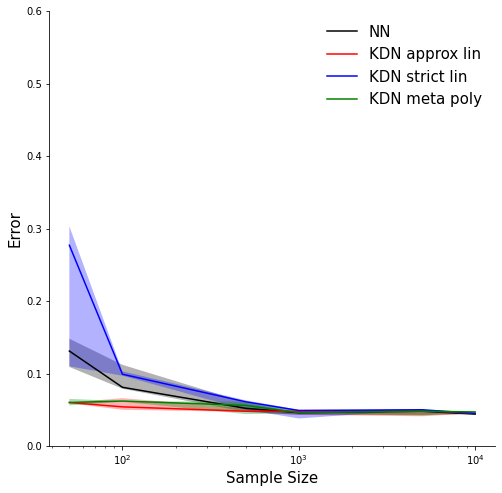

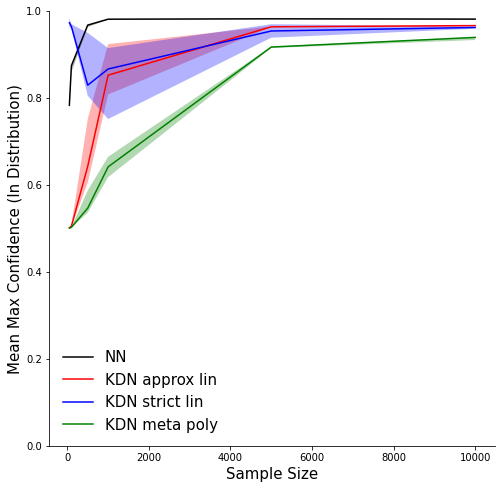

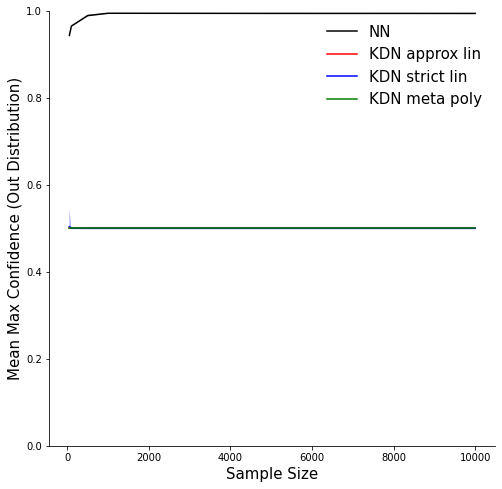

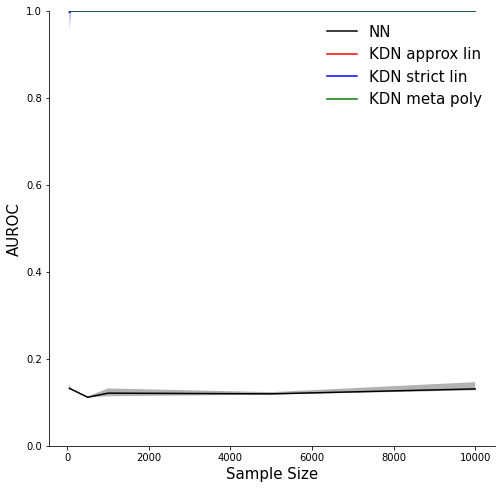

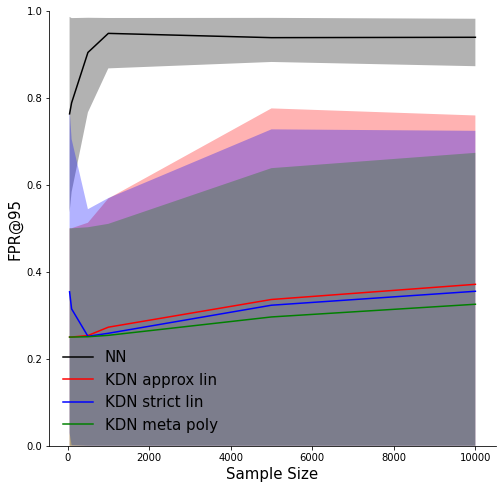

In [172]:
# plot the curves (without errorbars)
sample_size = [50, 100, 500, 1000, 5000, 10000]
metrics = ["acc", "mmcIn", "mmcOut", "roc", "fpr"]
names = ["nn", "kdn1", "kdn2", "kdn3"]
colors = ["k", "r", "b", "g"]
labels = ["NN", "KDN approx lin", "KDN strict lin", "KDN meta poly"]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, name in enumerate(names):
        param_med = []
        param_25_quantile = []
        param_75_quantile = []

        for sample in sample_size:
            if metric == "acc":
                param = 1 - np.array(ddf[name + "_" + metric])[np.array(ddf["sample"]) == sample]
            else:
                param = np.array(ddf[name + "_" + metric])[np.array(ddf["sample"]) == sample]
            s1, s2, s3 = compute_stats(param)
            param_med.append(s1)
            param_25_quantile.append(s2)
            param_75_quantile.append(s3)

        ax.plot(sample_size, param_med, c=colors[i], label=labels[i])
        ax.fill_between(
            sample_size, param_25_quantile, param_75_quantile, facecolor= colors[i], alpha=0.3
        )
        
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    if metric == "acc":
        ax.set_xscale("log")
        ax.set_ylim([0, 0.6])
        ax.set_ylabel("Error", fontsize=15)
    if metric == "mmcIn":
        ax.set_ylim([0, 1])
        ax.set_ylabel("Mean Max Confidence (In Distribution)", fontsize=15)    
    if metric == "mmcOut":
        ax.set_ylim([0, 1])
        ax.set_ylabel("Mean Max Confidence (Out Distribution)", fontsize=15) 
    if metric == "roc":
        ax.set_ylim([0, 1])
        ax.set_ylabel("AUROC", fontsize=15) 
    if metric == "fpr":
        ax.set_ylim([0, 1])
        ax.set_ylabel("FPR@95", fontsize=15) 
    ax.set_xlabel("Sample Size", fontsize=15)
    ax.legend(frameon=False, fontsize=15)
    

In [175]:
# save experiments data
savemat("experiments_data.mat", ddf)